In [278]:
#Import relevant packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from numpy import linalg as ln


LOAD SST DATA

In [3]:
#Path to SST file (downloaded locally)
sstpath = r"C:\Users\benja\Downloads\HadISST_sst.nc\HadISST_sst.nc"

#Open SST dataset in xarray
sstfile = xr.open_dataset(sstpath).sel(nv = 0)

SST DATA PREPROCESSING

In [4]:
#Change grid cells with likely full sea ice cover (stored as -1000) to NaN values
sstfile_icefilt = xr.where(sstfile.sst == -1000, np.nan, sstfile)

In [5]:
#Apply latitude weighting (square root of cosine of latitude)
sst_icefilt_coslat = sstfile_icefilt * np.sqrt(np.cos(np.deg2rad(sstfile_icefilt.latitude)))

In [6]:
#Get SST data field 
sstdata = sst_icefilt_coslat.sst

In [7]:
#Convert SST data to numpy array and reshape to (Time x (Lat * Lon))
sstdata_reshaped = sstdata.values.reshape([1859, 180*360])

In [8]:
#Get spatial indices (grid points) where no NaN values exist across all times in dataset
non_nan_idxs = np.array([i for i in range(len(sstdata_reshaped.mean(0)))])[~np.isnan(sstdata_reshaped.mean(0))]

#Get spatial indices (grid points) where NaN values exist for at least one time within dataset
nan_idxs = np.array([i for i in range(len(sstdata_reshaped.mean(0)))])[np.isnan(sstdata_reshaped.mean(0))]

In [154]:
#Remove all spatial points with NaN values at any time
sstdata_withseasons = sstdata_reshaped[:, non_nan_idxs].transpose()

In [10]:
#Get monthly mean data for all months

all_monthly_means = []
#Iterate over months
for j in range(12):
    #Get indices of time variable corresponding to selected month
    indices = [int(i * 12) + j for i in np.arange(sstdata_withseasons.shape[1] / 12)]
    #Correct for fact that the data ends in November, not December
    if j == 11:
        indices = indices[:len(indices) - 1]
    #Take mean of SST data across selected montly indices
    monthly_mean = sstdata_withseasons[:, indices].mean(1)
    all_monthly_means.append(monthly_mean)

#Get array of monthly mean data
all_monthly_means_array = np.array(all_monthly_means).transpose()

In [157]:
#Remove seasonal cycle


all_monthly_no_seasonal = []
#Iterate over each time index in dataset
for monthidx in range(sstdata_withseasons.shape[1]):
    j = np.mod(monthidx, 12)
    monthmean = all_monthly_means_array[:, j]
    #Remove monthly mean corresponding to month in dataset
    monthly_no_seasonal = sstdata_withseasons[:, monthidx] - monthmean
    all_monthly_no_seasonal.append(monthly_no_seasonal)

#Get array of data with seasonal cycle removed
sstdata_noseasons = np.array(all_monthly_no_seasonal).transpose()

In [12]:
#Call array X (centered data array)
X = sstdata_noseasons

In [177]:
#Check shape of data array
X.shape

(33706, 1859)

PCA via SVD

In [13]:
#Perform SVD on data array (note V here is what is typically called V^T)
[U, S, V] = ln.svd(X)

In [14]:
#Recreate full EOFs by adding removed NaN values back in, reshaping


recreated_modes_list = []
#Iterate over the first 10 EOFs
for modenum in range(10):
    recreated_mode = []
    nn_idx_ct = 0 #Count of non-NaN indices
    #Iterate over all lat/lons
    for i in range(180*360):
        #If index is not associated with NaN point in original dataset..
        if i in non_nan_idxs:
            #Append appropriate value from U matrix
            recreated_mode.append(U[nn_idx_ct, modenum])
            nn_idx_ct += 1
        else:
            #Else, append Nan
            recreated_mode.append(np.nan)
    recreated_modes_list.append(recreated_mode)

#Get array of first 10 EOFs
recreated_modes = np.array(recreated_modes_list)
    


In [213]:
#Mask array by NaN values
import numpy.ma as ma
recreated_modes_masked = ma.masked_invalid(recreated_modes)

In [225]:
#Get diagonal matrix with singular values in it
sigma_square = np.diag(S)

In [226]:
#Get Sigma*V (via matrix multiplication), which contains the principal components
sigmaV = sigma_square@V

In [279]:
#Get eigenvalues of covariance matrix from singular valuesd
n = X.shape[1]
evals = ((S**2)/n)


In [285]:
#Get explained variance ratios
print(((evals / sum(evals)) * 100)[0:3])

[26.20733   15.312101   3.5366888]


MAKE EOF and PC PLOTS

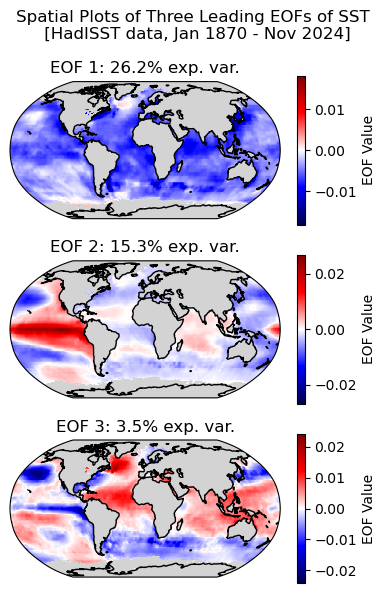

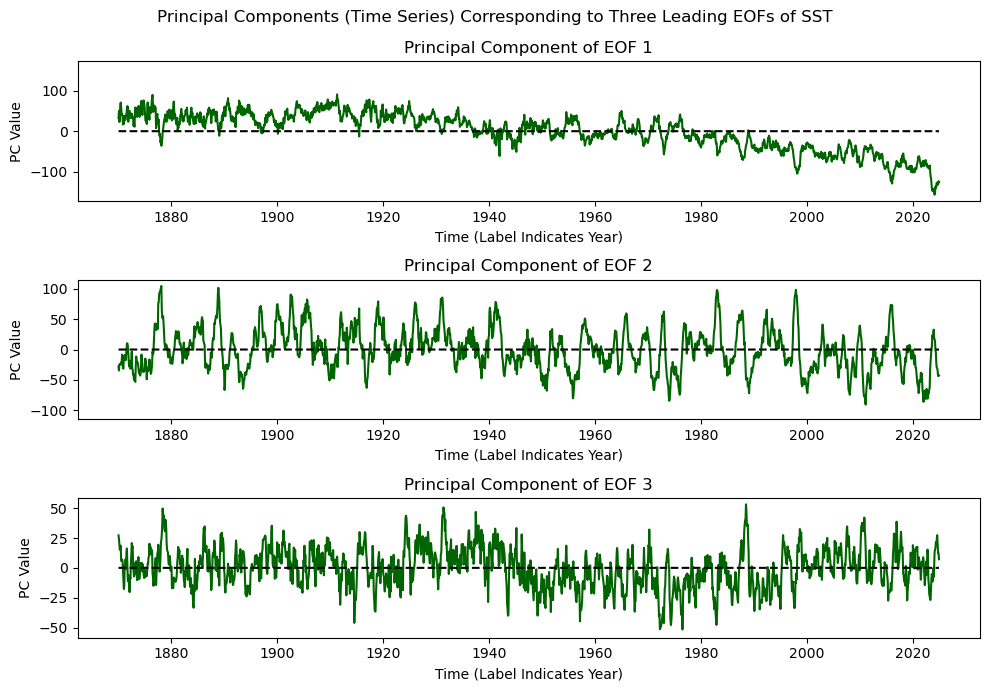

In [228]:
#Set up EOF plot figure
fig, ax = plt.subplots(3, 1, subplot_kw = {'projection': ccrs.Robinson()}, figsize = [4, 6])

plt.suptitle("Spatial Plots of Three Leading EOFs of SST \n [HadISST data, Jan 1870 - Nov 2024]", x = 0.5)

#Iterate through EOF indices
for k in range(3):
    ax[k].coastlines()
    #Used ChatGPT to get these 2 lines
    cmap = plt.cm.seismic
    cmap.set_bad('lightgray') #Set NaN values to gray
    vval = max(abs(np.nanmin(np.array(recreated_modes_masked[k, :]).reshape([180, 360]))), np.nanmax(np.array(recreated_modes[k, :]).reshape([180, 360])))
    #Plot EOFs on map
    pcm = ax[k].pcolormesh(sstdata.longitude, sstdata.latitude, np.array(recreated_modes[k, :]).reshape([180, 360]), cmap = cmap, vmin = -1*vval, vmax = vval, transform = ccrs.PlateCarree())
    plt.colorbar(pcm, label = 'EOF Value')
    ev = [26.2, 15.3, 3.5] #EOF explained variance ratios 
    ax[k].set_title("EOF " + str(k + 1) + ": " + str(ev[k]) + "% exp. var.")
plt.tight_layout()

#Set up PC time series figure
fig, ax = plt.subplots(3, 1, figsize = [10, 7])
plt.suptitle("Principal Components (Time Series) Corresponding to Three Leading EOFs of SST")
#Iterate through PC indices
for l in range(3):
    vval = np.nanmax(np.abs(sigmaV[l, :])) #y bounds
    ax[l].plot(sstdata.time, sigmaV[l, :], c = 'darkgreen') #Plot PC (row of V)
    ax[l].plot(sstdata.time, [0 for i in range(len(sstdata.time))], linestyle = '--', c = 'k')
    ax[l].set_ylim([-1.1*vval, 1.1*vval])
    ax[l].set_xlabel('Time (Label Indicates Year)')
    ax[l].set_ylabel('PC Value')
    ax[l].set_title("Principal Component of EOF " + str(l + 1))
plt.tight_layout()

MAKE SCREE PLOT

In [ ]:
#Take spatial mean SSTs
spatial_mean_data =  X.mean(0).reshape([X.shape[1],1])
#Calculate lag-1 autocorrelation of spatial mean SSTs
lag1_ac = np.corrcoef(spatial_mean_data[0:len(spatial_mean_data)-1][:, 0], spatial_mean_data[1:][:, 0])[0][1]
lag1_ac

0.9779693017119201

In [275]:
#Calculate effective sample size
n_true = n * ((1 - lag1_ac)/(1 + lag1_ac))

In [276]:
#Calculate error bounds on eigenvalues
ev_err = evals * np.sqrt(2/n_true)

Text(0.5, 1.0, 'Scree Plot of Eigenvalue Magnitudes and Error')

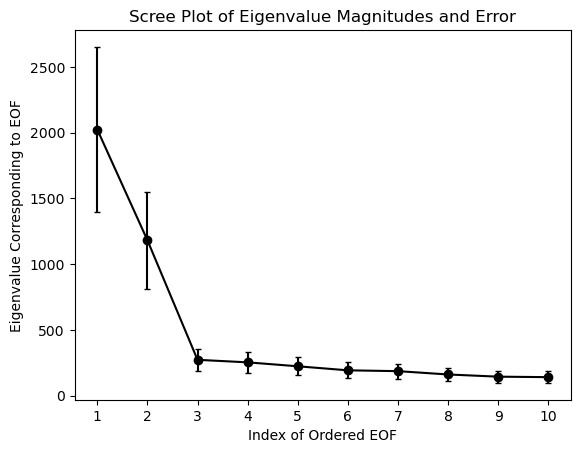

In [277]:
#Plot scree plot
plt.scatter(np.arange(1, 11), evals[0:10], c='k') #Plot eigenvalues
plt.errorbar(np.arange(1, 11), evals[0:10], yerr = ev_err[0:10], c='k', capsize = 2) #Plot eigenvalue error bars
plt.xlabel('Index of Ordered EOF')
plt.ylabel('Eigenvalue Corresponding to EOF')
plt.xticks(np.arange(1, 11))
plt.title("Scree Plot of Eigenvalue Magnitudes and Error")